In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import EarlyStopping

from lightgbm import LGBMRegressor
import random
import xgboost as xgb

In [2]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

from tensorflow.keras.layers import LSTM 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, SimpleRNN, GRU
import keras.backend as K 
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.optimizers import SGD

In [3]:
import datetime

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout

# DATA

In [4]:
submission = pd.read_csv('2-1_검증데이터셋.csv')
submission1 = submission.copy()
submission1             # "년도 월 일 시 분 => 년도 월 일"  예측

,yy,mm,dd,heat_supply_day1,heat_supply_day2
0,2022,3,4,NaN,NaN
1,2022,3,5,NaN,NaN
2,2022,3,6,NaN,NaN
3,2022,3,7,NaN,NaN
4,2022,3,8,NaN,NaN
5,2022,3,9,NaN,NaN
6,2022,3,10,NaN,NaN
7,2022,3,11,NaN,NaN
8,2022,3,12,NaN,NaN
9,2022,3,13,NaN,NaN


In [6]:
real1 = pd.read_csv('real_data_최종.csv', encoding='utf-8')
real1

,일자,10CM 정시 토양수분(%),20CM 정시 토양수분(%),30CM 정시 토양수분(%),50CM 정시 토양수분(%),smart_farm.insolation,smart_farm.out_tmperature,smart_farm.out_humidity,smart_farm.wind_speed,smart_farm.wind_direction,...,smart_farm.shield_tmperature_h,smart_farm.shield_energy_h,smart_farm.shield_energy_v,smart_farm.exhaust_fan,smart_farm.ceiling,smart_farm.floating_fan,smart_farm.fan_coil_b_site,smart_farm.ventilation_temperature_control,smart_farm.heating_temperature_set_up,smart_farm.heat_supply
0,2021-11-26 0:00,21.400000,22.190909,21.800000,24.372727,-3.221667,4.953333,70.383333,0.165000,229.550000,...,0.000000,0.0,0.0,0.0,0.0,1.000000,0.600000,28.000000,18.000000,46.8
1,2021-11-26 1:00,21.327273,22.172727,21.900000,24.381818,-3.326667,3.186667,78.033333,0.006667,270.200000,...,0.000000,0.0,0.0,0.0,0.0,1.000000,0.650000,28.000000,18.000000,48.7
2,2021-11-26 2:00,21.281818,22.127273,21.745455,24.372727,-3.553333,2.303333,81.900000,0.026667,260.500000,...,0.000000,0.0,0.0,0.0,0.0,1.000000,0.683333,28.000000,18.000000,45.0
3,2021-11-26 3:00,21.227273,22.109091,21.718182,24.372727,-3.753333,1.593333,83.416667,0.041667,248.266667,...,0.000000,0.0,0.0,0.0,0.0,1.000000,0.750000,28.000000,18.000000,46.0
4,2021-11-26 4:00,21.163636,22.072727,21.700000,24.363636,-3.736667,1.841667,80.516667,0.166667,266.850000,...,0.000000,0.0,0.0,0.0,0.0,1.000000,0.771930,28.000000,18.000000,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,2022-03-20 19:00,20.218182,21.172727,19.836364,22.627273,-2.696667,8.531667,55.366667,0.626667,157.850000,...,91.316667,0.0,0.0,0.0,0.0,1.000000,0.000000,27.866667,17.383333,0.0
2756,2022-03-20 20:00,20.172727,21.109091,19.800000,22.627273,-2.505000,7.941667,56.900000,0.826667,253.183333,...,0.200000,0.0,0.0,0.0,0.0,0.983333,0.000000,28.000000,15.478333,0.0
2757,2022-03-20 21:00,20.190909,21.072727,19.809091,22.609091,-2.288333,7.476667,57.616667,2.470000,311.216667,...,0.000000,0.0,0.0,0.0,0.0,0.966667,0.150000,28.000000,15.095000,0.0
2758,2022-03-20 22:00,20.136364,21.045455,19.854545,22.618182,-2.210000,7.453333,54.883333,2.333333,239.250000,...,0.000000,0.0,0.0,0.0,0.0,1.000000,0.616667,28.000000,16.616667,0.0


# EDA(전처리 완료 데이터셋으로)

In [53]:
# r = real1
# #[:-480]
# r.columns
# len(r.columns)
r1= real1[30*24:37*24]

주기성

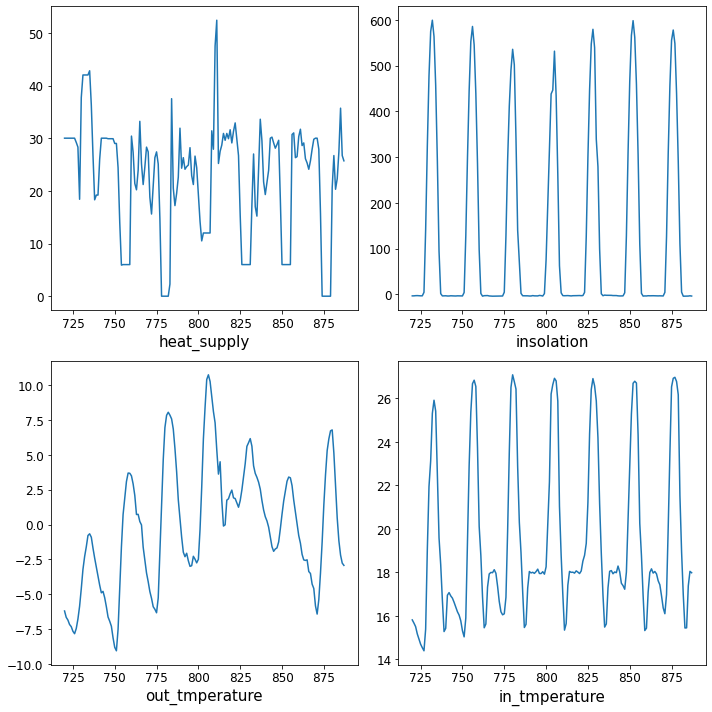

In [67]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
r1['smart_farm.heat_supply'].plot()
# plt.yticks([0,150])
plt.xlabel('heat_supply', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2,2,2)
r1['smart_farm.insolation'].plot()
# plt.yticks([0,150])
plt.xlabel('insolation', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2,2,3)
r1['smart_farm.out_tmperature'].plot()
# plt.yticks([-10,150])
plt.xlabel('out_tmperature', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2,2,4)
r1['smart_farm.in_tmperature'].plot()
# plt.yticks([0,150])
plt.xlabel('in_tmperature', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.tight_layout()
# plt.savefig('seasonal.png')

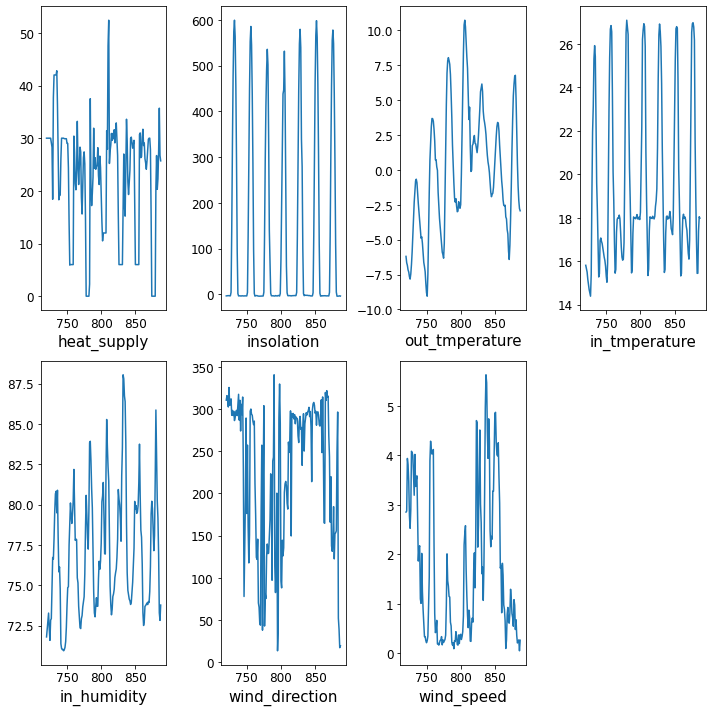

In [69]:
plt.figure(figsize=(10,10))
plt.subplot(2,4,1)
r1['smart_farm.heat_supply'].plot()
# plt.yticks([0,150])
plt.xlabel('heat_supply', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2,4,2)
r1['smart_farm.insolation'].plot()
# plt.yticks([0,150])
plt.xlabel('insolation', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2,4,3)
r1['smart_farm.out_tmperature'].plot()
# plt.yticks([-10,150])
plt.xlabel('out_tmperature', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2,4,4)
r1['smart_farm.in_tmperature'].plot()
# plt.yticks([0,150])
plt.xlabel('in_tmperature', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2,4,5)
r1['smart_farm.in_humidity'].plot()
# plt.yticks([0,150])
plt.xlabel('in_humidity', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2,4,6)
r1['smart_farm.wind_direction'].plot()
# plt.yticks([0,150])
plt.xlabel('wind_direction', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2,4,7)
r1['smart_farm.wind_speed'].plot()
# plt.yticks([0,150])
plt.xlabel('wind_speed', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig('seasonal1.png')

(array([0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

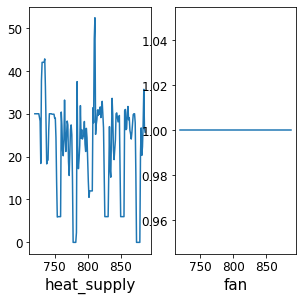

In [73]:
plt.figure(figsize=(10,10))
plt.subplot(2,4,1)
r1['smart_farm.heat_supply'].plot()
# plt.yticks([0,150])
plt.xlabel('heat_supply', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2,4,2)
r1['smart_farm.floating_fan'].plot()
# plt.yticks([0,150])
plt.xlabel('fan', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

In [71]:
r1.columns

Index(['일자', '10CM 정시 토양수분(%)', '20CM 정시 토양수분(%)', '30CM 정시 토양수분(%)',
       '50CM 정시 토양수분(%)', 'smart_farm.insolation', 'smart_farm.out_tmperature',
       'smart_farm.out_humidity', 'smart_farm.wind_speed',
       'smart_farm.wind_direction', 'smart_farm.in_tmperature',
       'smart_farm.in_humidity', 'smart_farm.shield_light_h',
       'smart_farm.shield_tmperature_h', 'smart_farm.shield_energy_h',
       'smart_farm.shield_energy_v', 'smart_farm.exhaust_fan',
       'smart_farm.ceiling', 'smart_farm.floating_fan',
       'smart_farm.fan_coil_b_site',
       'smart_farm.ventilation_temperature_control',
       'smart_farm.heating_temperature_set_up', 'smart_farm.heat_supply'],
      dtype='object')

<AxesSubplot:>

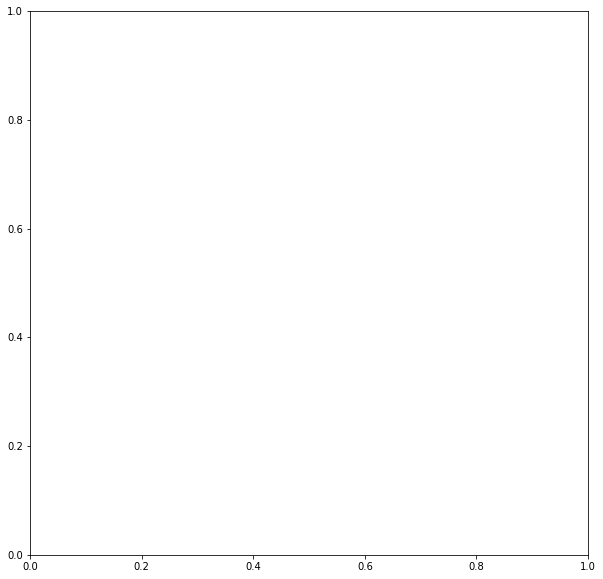

In [66]:
plt.figure(figsize=(10,10))
plt.subplot(2,4,1)
r1['smart_farm.heat_supply'].plot()
# plt.yticks([0,150])
plt.xlabel('heat_supply', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2,2,2)
r1['smart_farm.insolation'].plot()
# plt.yticks([0,150])
plt.xlabel('insolation', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2,2,3)
r1['smart_farm.out_tmperature'].plot()
# plt.yticks([-10,150])
plt.xlabel('out_tmperature', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2,2,4)
r1['smart_farm.in_tmperature'].plot()
# plt.yticks([0,150])
plt.xlabel('in_tmperature', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot()

Text(0.5, 0, 'out_tmperature')

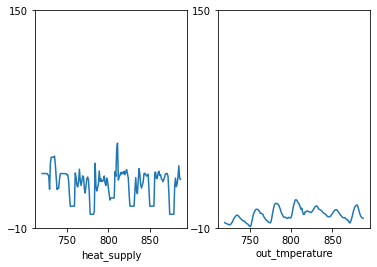

In [55]:
plt.subplot(1,2,1)
r1['smart_farm.heat_supply'].plot()
plt.yticks([-10,150])
plt.xlabel('heat_supply')

plt.subplot(1,2,2)
r1['smart_farm.out_tmperature'].plot()
plt.yticks([-10,150])
plt.xlabel('out_tmperature')

Text(0.5, 0, 'in_tmperature')

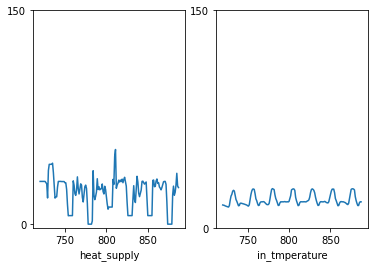

In [56]:
plt.subplot(1,2,1)
r1['smart_farm.heat_supply'].plot()
plt.yticks([0,150])
plt.xlabel('heat_supply')

plt.subplot(1,2,2)
r1['smart_farm.in_tmperature'].plot()
plt.yticks([0,150])
plt.xlabel('in_tmperature')

팬코일 돌아갈때 안 돌아갈 때 외부,내부 환경 차이   && 환경에 따라?/얼마나 지속되는지

In [16]:
data = list(r[r['smart_farm.heat_supply']==0].index)

from itertools import groupby
from operator import itemgetter


data = [ 1, 4,5,6, 10, 15,16,17,18, 22, 25,26,27,28]
for k, g in groupby(enumerate(data), lambda (i, x): i-x):
    print(map(itemgetter(1), g))

SyntaxError: invalid syntax (1706759233.py, line 8)

(array([ 2.,  3.,  1.,  1.,  2., 13., 17.,  1.,  3.,  1.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

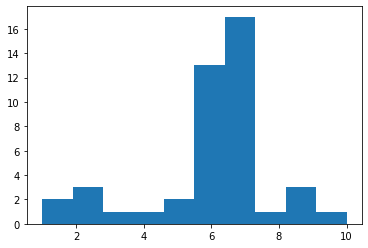

In [26]:
queue = list(r[r['smart_farm.heat_supply']==0].index)
packet =[]
tmp = []
v = queue.pop(0)
tmp.append(v)
# print(v)
while(len(queue)>0):
    vv = queue.pop(0)
#     print(vv)
    if v+1== vv:
        tmp.append(vv)
        v = vv
    else:
        packet.append(tmp)
        tmp = []
        tmp.append(vv)
        v = vv
packet.append(tmp)
# print(packet)

a=[]
for i in range(len(packet)):
    a.append(len(packet[i]))
plt.hist(a)

Text(0.5, 1.0, '10CM 정시 토양수분(%)')

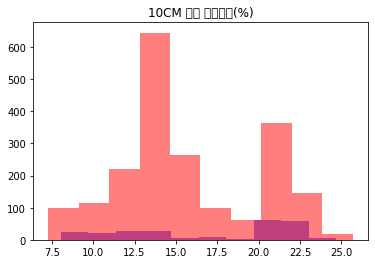

In [124]:
a=1
plt.hist(r[r['smart_farm.fan_coil_b_site']==0][r.columns[a]],alpha=0.5, color='blue')

plt.hist(r[r['smart_farm.fan_coil_b_site']!=0][r.columns[a]],alpha=0.5, color='red')

plt.title(r.columns[a])

Text(0.5, 1.0, 'smart_farm.insolation')

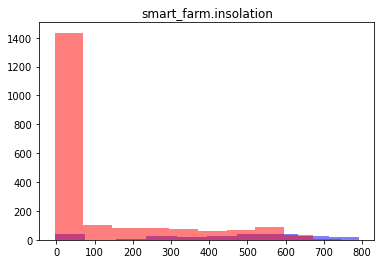

In [109]:
a=5
plt.hist(r[r['smart_farm.fan_coil_b_site']==0][r.columns[a]],alpha=0.5, color='blue')

plt.hist(r[r['smart_farm.fan_coil_b_site']!=0][r.columns[a]],alpha=0.5, color='red')

plt.title(r.columns[a])

Text(0.5, 1.0, 'smart_farm.out_tmperature')

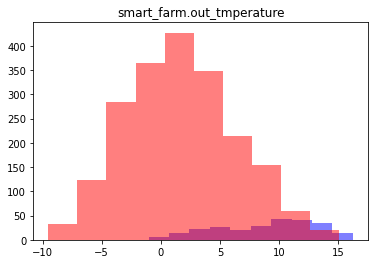

In [110]:
a=6
plt.hist(r[r['smart_farm.fan_coil_b_site']==0][r.columns[a]],alpha=0.5, color='blue')

plt.hist(r[r['smart_farm.fan_coil_b_site']!=0][r.columns[a]],alpha=0.5, color='red')

plt.title(r.columns[a])

Text(0.5, 1.0, 'smart_farm.out_humidity')

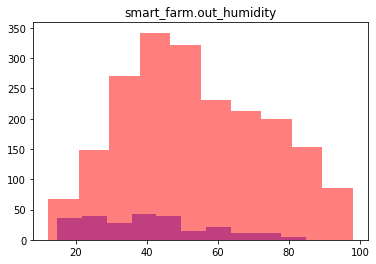

In [111]:
a=7
plt.hist(r[r['smart_farm.fan_coil_b_site']==0][r.columns[a]],alpha=0.5, color='blue')

plt.hist(r[r['smart_farm.fan_coil_b_site']!=0][r.columns[a]],alpha=0.5, color='red')

plt.title(r.columns[a])

Text(0.5, 1.0, 'smart_farm.wind_speed')

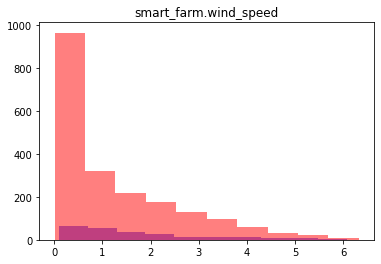

In [112]:
a=8
plt.hist(r[r['smart_farm.fan_coil_b_site']==0][r.columns[a]],alpha=0.5, color='blue')

plt.hist(r[r['smart_farm.fan_coil_b_site']!=0][r.columns[a]],alpha=0.5, color='red')

plt.title(r.columns[a])

Text(0.5, 1.0, 'smart_farm.wind_direction')

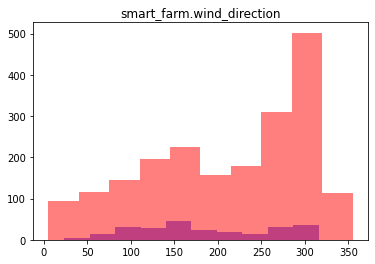

In [113]:
a=9
plt.hist(r[r['smart_farm.fan_coil_b_site']==0][r.columns[a]],alpha=0.5, color='blue')

plt.hist(r[r['smart_farm.fan_coil_b_site']!=0][r.columns[a]],alpha=0.5, color='red')

plt.title(r.columns[a])

Text(0.5, 1.0, 'smart_farm.in_tmperature')

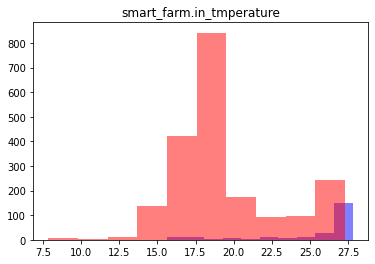

In [114]:
a=10
plt.hist(r[r['smart_farm.fan_coil_b_site']==0][r.columns[a]],alpha=0.5, color='blue')

plt.hist(r[r['smart_farm.fan_coil_b_site']!=0][r.columns[a]],alpha=0.5, color='red')

plt.title(r.columns[a])

Text(0.5, 1.0, 'smart_farm.in_humidity')

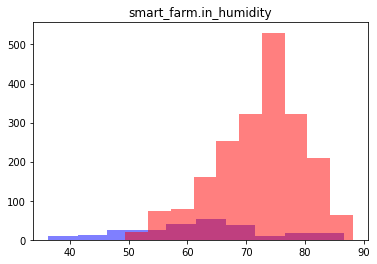

In [115]:
a=11
plt.hist(r[r['smart_farm.fan_coil_b_site']==0][r.columns[a]],alpha=0.5, color='blue')

plt.hist(r[r['smart_farm.fan_coil_b_site']!=0][r.columns[a]],alpha=0.5, color='red')

plt.title(r.columns[a])

In [ ]:
'smart_farm.insolation', 'smart_farm.out_tmperature',
       'smart_farm.out_humidity', 'smart_farm.wind_speed',
       'smart_farm.wind_direction', 'smart_farm.in_tmperature',
       'smart_farm.in_humidity',

열 공급량 범위

<AxesSubplot:>

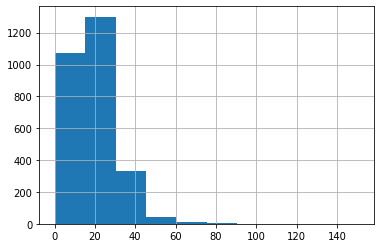

In [7]:
## 열 공급량 범위
real1['smart_farm.heat_supply'].hist()

In [8]:
real1.columns

Index(['일자', '10CM 정시 토양수분(%)', '20CM 정시 토양수분(%)', '30CM 정시 토양수분(%)',
       '50CM 정시 토양수분(%)', 'smart_farm.shield_light_h',
       'smart_farm.shield_tmperature_h', 'smart_farm.shield_energy_h',
       'smart_farm.shield_energy_v', 'smart_farm.exhaust_fan',
       'smart_farm.ceiling', 'smart_farm.floating_fan',
       'smart_farm.fan_coil_b_site',
       'smart_farm.ventilation_temperature_control',
       'smart_farm.heating_temperature_set_up', 'smart_farm.heat_supply'],
      dtype='object')

<AxesSubplot:>

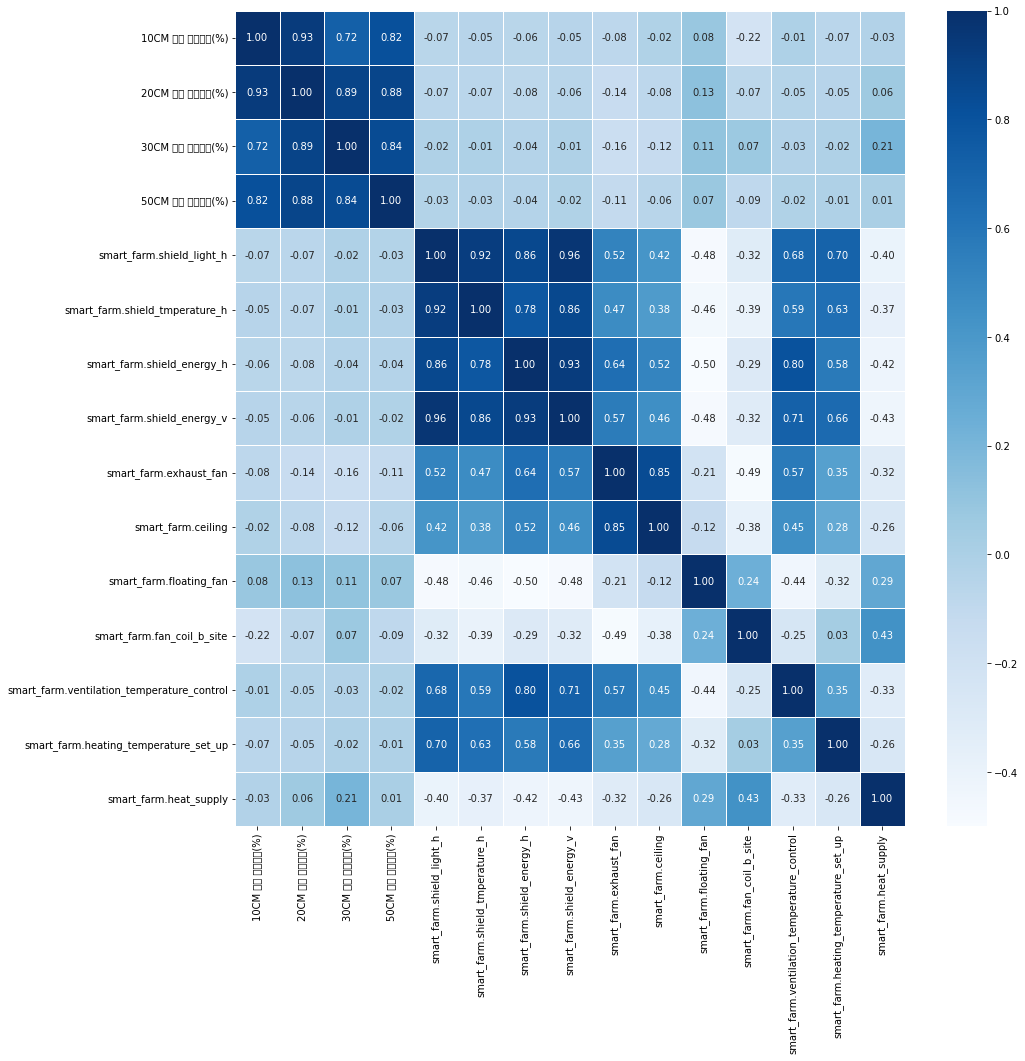

In [21]:
plt.figure(figsize=(15,15))
sns.heatmap(data = real1.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

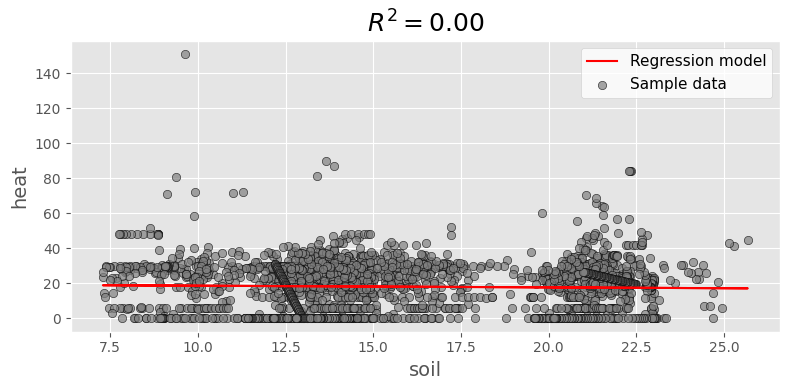

In [45]:
# 시계열이 아닌 그냥 데이터 자체로 둘의 상관관계는 전혀 없다

import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

X = real1['10CM 정시 토양수분(%)'].values.reshape(-1,1)
y = real1['smart_farm.heat_supply'].values


ols = linear_model.LinearRegression()
model = ols.fit(X, y)
response = model.predict(X)


r2 = model.score(X, y)

############################################## Plot ################################################

plt.style.use('default')
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(X, response, color='red', label='Regression model')
ax.scatter(X, y, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
ax.set_ylabel('heat', fontsize=14)
ax.set_xlabel('soil', fontsize=14)
# ax.text(0.8, 0.1, 'aegis4048.github.io', fontsize=13, ha='center', va='center',
#          transform=ax.transAxes, color='grey', alpha=0.5)
ax.legend(facecolor='white', fontsize=11)
ax.set_title('$R^2= %.2f$' % r2, fontsize=18)

fig.tight_layout()
# plt.savefig('reg_esr.png')

열 공급량 + 토양 수분  vs 열공급량 => 값이 줄어드는 이유

([<matplotlib.axis.YTick at 0x2626c88fa90>,
 [Text(0, 0, ''), Text(0, 0, '')])

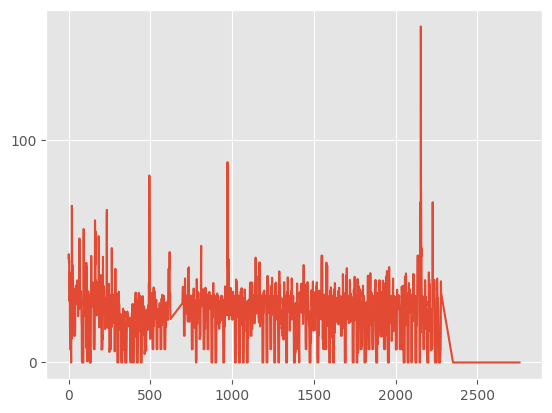

In [50]:
real1['smart_farm.heat_supply'].plot()
plt.yticks([0,100])

([<matplotlib.axis.YTick at 0x23ab27b74c0>,
 [Text(0, 0, ''), Text(0, 0, '')])

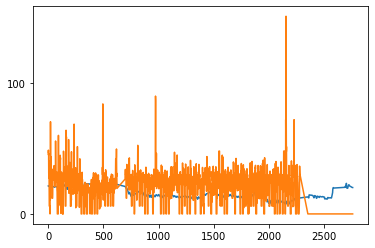

In [43]:
real1["10CM 정시 토양수분(%)"].plot()
real1['smart_farm.heat_supply'].plot()
plt.yticks([0,100])

In [36]:
max(real1['smart_farm.heat_supply'].values)

151.0

([<matplotlib.axis.YTick at 0x2626bc37fd0>,
 [Text(0, 0, ''), Text(0, 0, '')])

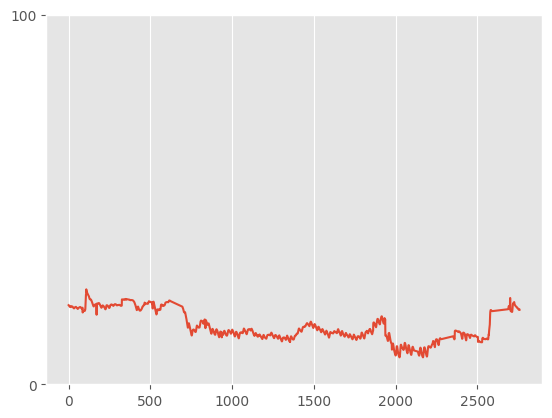

In [51]:
real1["10CM 정시 토양수분(%)"].plot()
plt.yticks([0,100])       # 다들 열 공급량과 관해 주기모양 비슷허나, 토양 수분만 조금 다름
# 위에서 열 공급량 부분 급격히 삐죽 올라간 부분 그 지점에서 soil은 가장 낮다. 고로 이러한 부분을 보완해 떨어뜨리는 기능.(관련 그림 추가)
# 다만, 이는 위에서 주기성으로 접근하는 대신에 시계열 데이터에서만 우리는 이러한 원리를 적용한다고 제한하고 감!!!

([<matplotlib.axis.YTick at 0x23ab26d39a0>,
 [Text(0, 0, ''), Text(0, 0, '')])

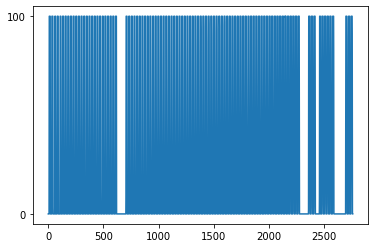

In [40]:
real1['smart_farm.shield_tmperature_h'].plot()
plt.yticks([0,100])

([<matplotlib.axis.YTick at 0x23ab2762970>,
 [Text(0, 0, ''), Text(0, 0, '')])

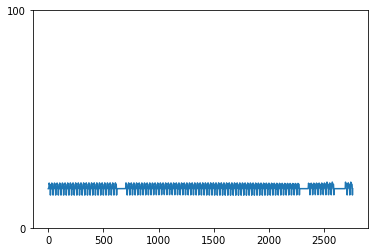

In [42]:
real1['smart_farm.heating_temperature_set_up'].plot()
plt.yticks([0,100])

([<matplotlib.axis.YTick at 0x23ab26bd250>,
 [Text(0, 0, ''), Text(0, 0, '')])

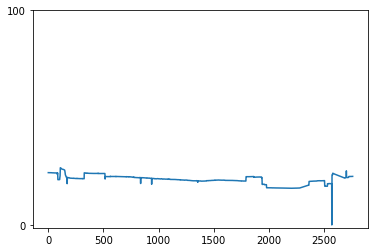

In [39]:
real1["50CM 정시 토양수분(%)"].plot()  # 토양수분끼리 생긴건 비슷함 조금 다를순있어도
plt.yticks([0,100])

식물 생장범위(난방온도)

In [6]:
real1.columns

Index(['일자', '10CM 정시 토양수분(%)', '20CM 정시 토양수분(%)', '30CM 정시 토양수분(%)',
       '50CM 정시 토양수분(%)', 'smart_farm.shield_light_h',
       'smart_farm.shield_tmperature_h', 'smart_farm.shield_energy_h',
       'smart_farm.shield_energy_v', 'smart_farm.exhaust_fan',
       'smart_farm.ceiling', 'smart_farm.floating_fan',
       'smart_farm.fan_coil_b_site',
       'smart_farm.ventilation_temperature_control',
       'smart_farm.heating_temperature_set_up', 'smart_farm.heat_supply'],
      dtype='object')

<AxesSubplot:>

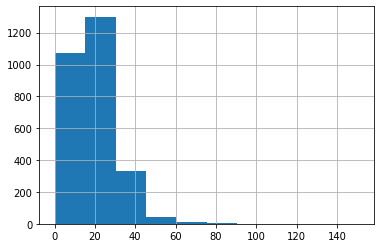

In [11]:
## 열 공급량 범위
real1['smart_farm.heat_supply'].hist()

<AxesSubplot:>

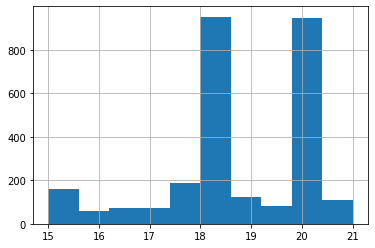

In [10]:
real1['smart_farm.heating_temperature_set_up'].hist()

<AxesSubplot:>

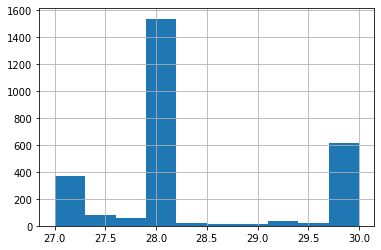

In [12]:
real1['smart_farm.ventilation_temperature_control'].hist()

In [16]:
heating = real1['smart_farm.heating_temperature_set_up'].values

h = []
for i in range(int(len(heating)/24)):   # 하루치의 어떤 난방온도. 이를 평균내면, 일자의 난방온도 평균이됨.
    h.append(np.sum(heating[24*i:24*(i+1)]))

h        # 난방온도(내부온도를 작물생장에 적합하도록 열을 공급하기 위해 설정된 온도)보다 많이 떨어질 수록(?) 좋은 점수?

[446.62166665999996,
 446.88666667,
 446.66833333,
 446.78916666,
 446.69500000999994,
 446.56833334,
 446.71166666,
 446.62833333000003,
 446.57833332999996,
 446.54499999,
 446.55166665999997,
 446.51500001,
 446.48000001,
 446.44333333,
 446.49166665999996,
 446.44833335,
 446.39166668,
 446.37333334,
 446.36333333000005,
 446.37000001,
 446.33666668,
 446.31166666,
 446.37166665,
 446.31333331999997,
 446.30166667000003,
 446.30833335,
 432.0,
 432.0,
 432.0,
 446.31166666999997,
 446.34166667,
 446.37666665999996,
 446.34499999999997,
 446.375,
 446.41666667000004,
 446.42000000999997,
 446.41,
 446.42166665,
 446.48000001,
 446.405,
 446.56999999,
 446.55166666,
 446.64500000000004,
 446.635,
 446.63833332,
 446.65833334,
 446.72166667,
 446.77333333,
 446.80833334,
 446.84166667,
 446.86333334,
 446.91333333,
 446.97499999999997,
 447.00166665999996,
 447.12333334,
 447.19,
 447.20666667,
 447.27000001,
 447.33999999,
 447.32666665,
 447.40833333,
 447.49000001,
 447.54,
 447.56

기상 예보 데이터 추가 후 추가 전 추이 비교

In [18]:
df = pd.read_csv('220224_soil_timeseries_sum_nooutlier.csv')
df

,yy,mm,dd,heat_supply_day1,heat_supply_day2
0,2022,3,4,361.10930,326.59006
1,2022,3,5,364.12585,354.74000
2,2022,3,6,364.23383,352.80676
3,2022,3,7,383.00568,365.83606
4,2022,3,8,373.86273,333.45770
5,2022,3,9,372.11963,358.92780
6,2022,3,10,365.76437,358.98800
7,2022,3,11,363.28418,350.50400
8,2022,3,12,365.08502,350.05893
9,2022,3,13,371.89770,347.73572


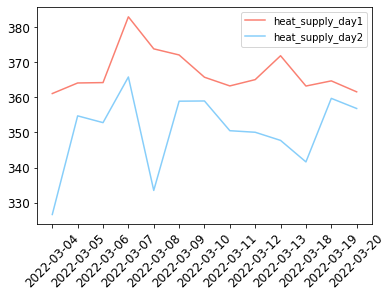

In [30]:
X = ['2022-03-04', '2022-03-05', '2022-03-06', '2022-03-07', '2022-03-08', '2022-03-09', '2022-03-10', \
    '2022-03-11', '2022-03-12', '2022-03-13', '2022-03-18', '2022-03-19', '2022-03-20']
y1 = df['heat_supply_day1'].values
y2 = df['heat_supply_day2'].values

plt.plot(X, y1, color='salmon', label='heat_supply_day1')
plt.plot(X, y2, color='lightskyblue', label='heat_supply_day2')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
# plt.savefig('compare.png')
plt.legend()

In [25]:
# training = real1[:-504]
# testing = real1[-504:]
# testing = testing.reset_index()
# testing = testing.drop('index', axis=1)
# testing
# training

,일자,10CM 정시 토양수분(%),20CM 정시 토양수분(%),30CM 정시 토양수분(%),50CM 정시 토양수분(%),smart_farm.shield_light_h,smart_farm.shield_tmperature_h,smart_farm.shield_energy_h,smart_farm.shield_energy_v,smart_farm.exhaust_fan,smart_farm.ceiling,smart_farm.floating_fan,smart_farm.fan_coil_b_site,smart_farm.ventilation_temperature_control,smart_farm.heating_temperature_set_up,smart_farm.heat_supply
0,2021-11-26 0:00,21.400000,22.190909,21.800000,24.372727,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.600000,28.0,18.000000,46.8
1,2021-11-26 1:00,21.327273,22.172727,21.900000,24.381818,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.650000,28.0,18.000000,48.7
2,2021-11-26 2:00,21.281818,22.127273,21.745455,24.372727,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.683333,28.0,18.000000,45.0
3,2021-11-26 3:00,21.227273,22.109091,21.718182,24.372727,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.750000,28.0,18.000000,46.0
4,2021-11-26 4:00,21.163636,22.072727,21.700000,24.363636,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.783333,28.0,18.000000,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,2022-02-27 19:00,12.181818,13.927273,13.500000,17.163636,0.0,58.216667,0.0,0.0,0.0,0.0,1.0,0.000000,28.0,16.716667,0.4
2252,2022-02-27 20:00,12.181818,14.018182,13.536364,17.172727,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.166667,28.0,15.128333,13.1
2253,2022-02-27 21:00,12.145455,14.063636,13.554545,17.172727,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.750000,28.0,15.411667,35.4
2254,2022-02-27 22:00,12.081818,14.100000,13.545455,17.181818,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.900000,28.0,17.263333,37.4
